In [1]:
from MuZero import MuZero

from GridWorldOption import GridWorldOption, GridWorldMacroAction
from GridWorld import GridWorld

from mcts.MCTS import MCTS
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
import time

import pickle
import pandas as pd

from matplotlib.pyplot import figure
import itertools
from tqdm import tqdm

import random


np.random.seed(30)
random.seed(30)

In [2]:
MAP_NAME = './maps/door.map'

options = [
      GridWorldOption((0, 0),  {'all'}, 0, 0),
      GridWorldOption((0, 0),  {'all'}, 1, 1),
      GridWorldOption((0, 0),  {'all'}, 2, 2),
      GridWorldOption((0, 0),  {'all'}, 3, 3)
]

with open(MAP_NAME) as f:
    the_map = f.read()

In [3]:
SIMULATIONS = 30
SIM_FINISHS = 30000
GAMES = 500
ALPHA=0.01

In [4]:
env = GridWorld(the_map, SIM_FINISHS)
mu = MuZero(env, options)

In [5]:
start = time.time()
returns = mu.learn(GAMES, SIMULATIONS, alpha=ALPHA)

end = time.time()

100%|██████████| 500/500 [03:55<00:00,  2.12it/s]


In [6]:
env = GridWorld(the_map, SIM_FINISHS)
env.reset()

total_return = 0
done = False

states = []
while not done:
    s0 = mu.h.forward(env)

    mcts = MCTS(s0, mu.f, mu.g, mu.options)
    pi, v = mcts.pred_model.forward(s0, [])
    #pi = mcts.run_sim(SIMULATIONS)

    #opt = np.random.choice(mu.options, 1, p=pi)[0]
    opt_index = np.argmax(pi)
    opt = mu.options[opt_index]
    
    while True:
        action, should_break = opt.get_action(env)
        
        if action == -1 or done:
            break
        
        s, r, done = env.step(action)
        states.append(s)

        total_return += r
        
        if should_break:
            break

print(total_return)

-24.0


In [7]:
with open(MAP_NAME) as f:
    env_map = f.read()
    
env_map = env_map.split('\n')[4:]


grid = np.zeros((len(env_map), len(env_map[0])))
for i in range(len(env_map)):
    for j in range(len(env_map[0])):
        if env_map[i][j] != '.':
            grid[i][j] = -1
        else:
            grid[i][j] = 0

In [8]:
mini = min(mu.f.v_table.values())
maxi = max(mu.f.v_table.values())
for k, v in mu.f.v_table.items():
    grid[k] = (v - mini)/(maxi-mini)

[]

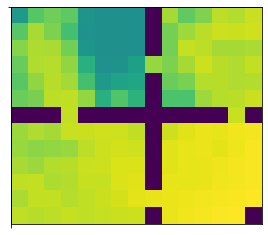

In [9]:
_, ax = plt.subplots()
ax.imshow(grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

In [10]:
play_grid = deepcopy(grid)

In [11]:
for s in states:
    play_grid[s] = 2

[]

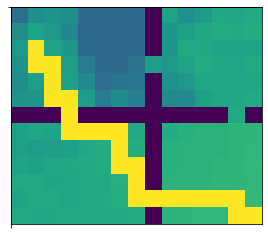

In [12]:
_, ax = plt.subplots()
ax.imshow(play_grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

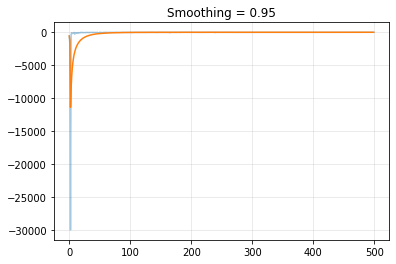

In [13]:
df = pd.DataFrame(data = {'value': np.array(returns[0:])})

SMOOTHING = 0.95
smooth = df.ewm(alpha=(1 - SMOOTHING)).mean()


plt.plot(df["value"], alpha=0.4)
plt.plot(smooth["value"])
plt.title("Smoothing = {}".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.show()

In [14]:
first_room_pos = [(i,j) for i in range(6) for j in range(8)]
second_room_pos = [(i,j) for i in range(6) for j in range(9, 15)]
third_room_pos = [(i,j) for i in range(7,13) for j in range(8)]
fourth_room_pos = [(i,j) for i in range(7,13) for j in range(9,15)]

options = [
  # primitives, (0,0) is meaningless
  GridWorldOption((0, 0),   {'all'}, 0, 0),
  GridWorldOption((0, 0),   {'all'}, 1, 1),
  GridWorldOption((0, 0),   {'all'}, 2, 2),
  GridWorldOption((0, 0),   {'all'}, 3, 3),
  GridWorldOption((3,8),  set(first_room_pos + second_room_pos + [(6,3)] + [(6,13)]), 4),
  GridWorldOption((6,3),  set(first_room_pos + third_room_pos + [(3,8)] + [(11,8)]), 5),
  GridWorldOption((6,13), set(second_room_pos + fourth_room_pos + [(3,8)] + [(11,8)]), 6),
  GridWorldOption((11,8), set(third_room_pos + fourth_room_pos + [(6,3)] + [(6,13)]), 7),
]

with open(MAP_NAME) as f:
    the_map = f.read()
    
env = GridWorld(the_map, SIM_FINISHS )
mu_opt = MuZero(env, options)
#mu_opt.g.model_table = G_model

In [15]:
start = time.time()
returns_options = mu_opt.learn(GAMES, SIMULATIONS, alpha=ALPHA)
end = time.time()

100%|██████████| 500/500 [02:28<00:00,  3.37it/s]


In [16]:
env = GridWorld(the_map, 1000)
env.reset()

total_return = 0
done = False

states = []
options = []
mu_p = mu_opt
while not done:
    s0 = mu_p.h.forward(env)

    mcts = MCTS(s0, mu_p.f, mu_p.g, mu_p.options)
    pi, v = mcts.pred_model.forward(s0, [])
    pi = mcts.run_sim(40)

    opt = np.random.choice(mu_p.options, 1, p=pi)[0]
    #opt_index = np.argmax(pi)
    #opt = mu_p.options[opt_index]
    
    options.append(opt)
    states_by_opt = []
    while True:
        action, should_break = opt.get_action(env)
        
        if action == -1 or done:
            break
        
        s, r, done = env.step(action)
        states_by_opt.append(s)
        

        total_return += r
        
        if should_break:
            break
        
    states.append(states_by_opt)

print(total_return)

-24.0


[]

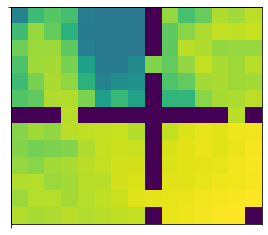

In [17]:
mini = min(mu_p.f.v_table.values())
maxi = max(mu_p.f.v_table.values())
for k, v in mu.f.v_table.items():
    grid[k] = (v - mini)/(maxi-mini)

_, ax = plt.subplots()
ax.imshow(grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

In [18]:
options

[4, 6, 1, 1, 1, 1, 2, 1, 1]

[]

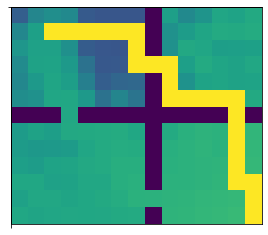

In [19]:
play_grid = deepcopy(grid)
for s in list(itertools.chain(*states)):
    play_grid[s] = 2
_, ax = plt.subplots()
ax.imshow(play_grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

In [20]:
options = [
    # primitives, (0,0) is meaningless
    GridWorldOption((0, 0),   {'all'}, 0, 0),
    GridWorldOption((0, 0),   {'all'}, 1, 1),
    GridWorldOption((0, 0),   {'all'}, 2, 2),
    GridWorldOption((0, 0),   {'all'}, 3, 3),
    GridWorldMacroAction(0, 3, 4),
    GridWorldMacroAction(1, 3, 5),
    GridWorldMacroAction(2, 3, 6),
    GridWorldMacroAction(3, 3, 7),
    
]

with open(MAP_NAME) as f:
    the_map = f.read()
    
env = GridWorld(the_map, SIM_FINISHS)
mu_ma = MuZero(env, options)


In [21]:
start = time.time()
returns_ma = mu_ma.learn(GAMES, SIMULATIONS, alpha=ALPHA)
end = time.time()

100%|██████████| 500/500 [00:53<00:00,  9.34it/s]


In [22]:
env = GridWorld(the_map, 1000)
env.reset()

total_return = 0
done = False

states = []
options = []
mu_p = mu_ma
while not done:
    s0 = mu_p.h.forward(env)

    mcts = MCTS(s0, mu_p.f, mu_p.g, mu_p.options)
    pi, v = mcts.pred_model.forward(s0, [])
    #pi = mcts.run_sim(40)

    #opt = np.random.choice(mu_p.options, 1, p=pi)[0]
    opt_index = np.argmax(pi)
    opt = mu_p.options[opt_index]
    
    options.append(opt)
    states_by_opt = []
    while True:
        action, should_break = opt.get_action(env)
        
        if action == -1 or done:
            break
        
        s, r, done = env.step(action)
        states_by_opt.append(s)
        

        total_return += r
        
        if should_break:
            break
        
    states.append(states_by_opt)

print(total_return)

-24.0


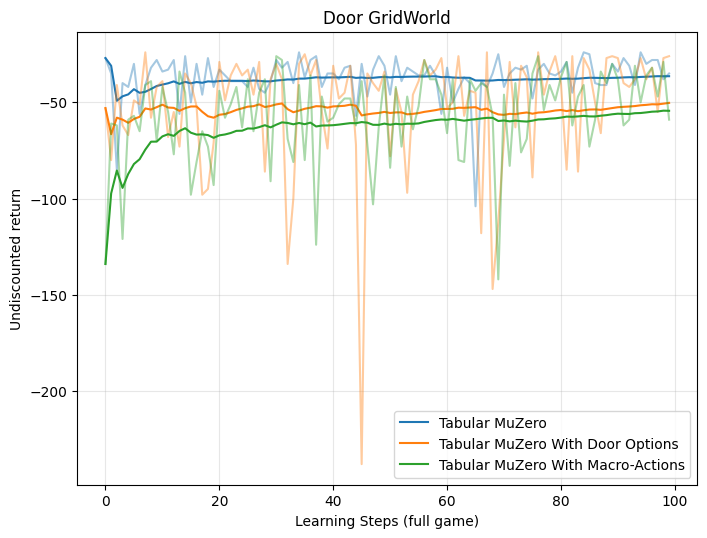

In [42]:

return_start_index = 100
end_index = 200
df = pd.DataFrame(data = {'value': np.array(returns[return_start_index:end_index])})
df_options = pd.DataFrame(data = {'value': np.array(returns_options[return_start_index:end_index])})
df_ma = pd.DataFrame(data = {'value': np.array(returns_ma[return_start_index:end_index])})

figure(figsize=(8, 6), dpi=100)

SMOOTHING = 0.99
smooth = df.ewm(alpha=(1 - SMOOTHING)).mean()
smooth_options = df_options.ewm(alpha=(1 - SMOOTHING)).mean()
smooth_ma = df_ma.ewm(alpha=(1 - SMOOTHING)).mean()

plt.plot(df["value"], alpha=0.4, color='#1f77b4')
plt.plot(smooth["value"], color='#1f77b4', label='Tabular MuZero')
plt.plot(df_options["value"], alpha=0.4, color='#ff7f0e')
plt.plot(smooth_options["value"], color='#ff7f0e', label='Tabular MuZero With Door Options')
plt.plot(df_ma["value"], alpha=0.4, color='#2ca02c')
plt.plot(smooth_ma["value"], color='#2ca02c', label='Tabular MuZero With Macro-Actions')

plt.title("Door GridWorld".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.xlabel("Learning Steps (full game)")
plt.ylabel("Undiscounted return")
plt.legend()
plt.show()

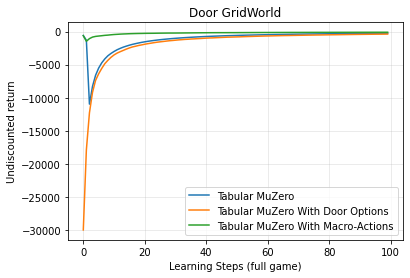

In [26]:
plt.plot(smooth["value"], color='#1f77b4', label='Tabular MuZero')
plt.plot(smooth_options["value"], color='#ff7f0e', label='Tabular MuZero With Door Options')
plt.plot(smooth_ma["value"], color='#2ca02c', label='Tabular MuZero With Macro-Actions')

plt.title("Door GridWorld".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.xlabel("Learning Steps (full game)")
plt.ylabel("Undiscounted return")
plt.legend()
plt.show()